## ETF backtesing  
I choose [backtrader](https://www.backtrader.com/) as the framework of the backtesting model, the reason is that it has fully document and is relatively flexible, helpful to focus on trading strategy.  
* Here I'll test at least 5 strategies, strategy 1 & 2 is for testing and the common strategies which could conpare with our own strategies. Strategy 3-5 is based on market sentiment or index.   
Stretegy  
> 1 TestStrategy    
> 2 MA_CrossOver  
> 3 VIX  
> 4 Sentiment  


In [27]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import pandas as pd
# Import the backtrader platform
import backtrader as bt
import backtrader.indicators as btind

# to avoid plot disappear everytime rerun the code
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#plt.figure(figsize=(15,5))

In [28]:
# create a data feed and set formet
data_1 = bt.feeds.GenericCSVData(dataname='data0.csv',
    
fromdate=datetime.datetime(2015, 5, 1), # startdate
todate=datetime.datetime(2019, 1, 1), # enddate
                                     
dtformat=('%Y-%m-%d'),tmformat=('%H.%M.%S'),
    date=0, open=1, close=2, high=3, low=4,
    volume=5, openinterest=6, code=-1,
    reverse=False)

In [29]:
# Create a Stratey #Buy if price continuelly fall for 3d & Sell every 5d
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
                
        # To keep track of pending orders #掛單
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                                
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None      
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))    
    
    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):  # 每過5天 -> sell!
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [24]:
class RSI_Strategy(bt.Strategy):

    def __init__(self):
        self.rsi = bt.indicators.RSI_SMA(self.data.close, period=21)

    def next(self):
        if not self.position:
            if self.rsi < 30:
                self.buy(size=100)
        else:
            if self.rsi > 70:
                self.sell(size=100)

In [19]:
class MA_CrossOver(bt.Strategy):
    '''This is a long-only strategy which operates on a moving average cross
    Note:
      - Although the default
    Buy Logic:
      - No position is open on the data
      - The ``fast`` moving averagecrosses over the ``slow`` strategy to the
        upside.
    Sell Logic:
      - A position exists on the data
      - The ``fast`` moving average crosses over the ``slow`` strategy to the
        downside
    Order Execution Type:
      - Market
    '''
    alias = ('SMA_CrossOver',)

    params = (
        # period for the fast Moving Average
        ('fast', 10),
        # period for the slow moving average
        ('slow', 30),
        # moving average to use
        ('_movav', btind.MovAv.SMA)
    )

    def __init__(self):
        sma_fast = self.p._movav(period=self.p.fast)
        sma_slow = self.p._movav(period=self.p.slow)

        self.buysig = btind.CrossOver(sma_fast, sma_slow)

    def next(self):
        if self.position.size:
            if self.buysig < 0:
                self.sell()

        elif self.buysig > 0:
            self.buy()

In [30]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10, 8  # that's default image size for this interactive session

pylab.rcParams['font.family'] = 'Segoe Script'
pylab.rcParams['font.sans-serif'] = ['Segoe Script']

#pylab.rcParams['font.family'] = 'sans-serif'
#pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
pylab.rcParams["font.size"] = "10"

Starting Portfolio Value: 100000.00
Final Portfolio Value: 100041.34


<IPython.core.display.Javascript object>


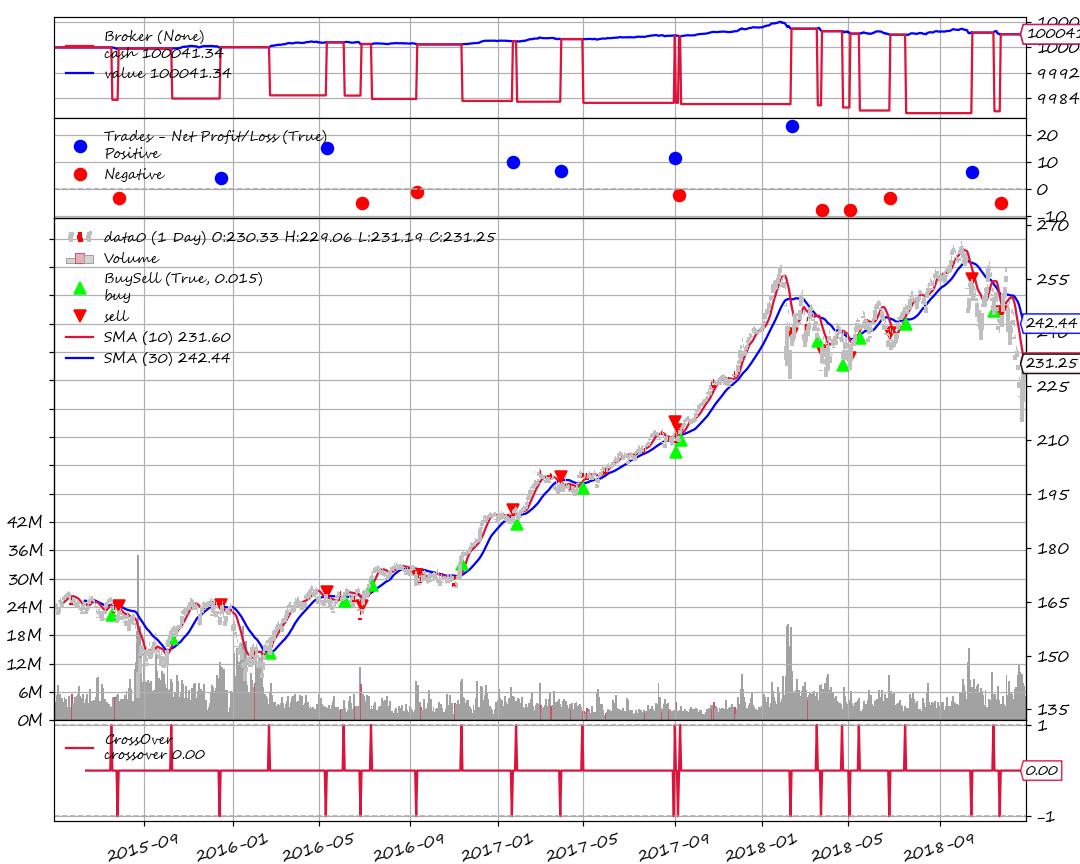

In [22]:
if __name__ == '__main__':
    
    cerebro = bt.Cerebro() # creat the "brain"

    # Add a strategy
    cerebro.addstrategy(MA_CrossOver)

    cerebro.adddata(data_1)
    
    cerebro.broker.setcash(100000.0) # the "manager"
    
    # Set the commission - 0.1% ... divide by 100 to remove the % #手續費
    cerebro.broker.setcommission(commission=0.001)
    
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.run() # run over everything
    
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue()) 
    
    cerebro.plot() # plot the result

Starting Portfolio Value: 100000.00
Final Portfolio Value: 102119.15


<IPython.core.display.Javascript object>


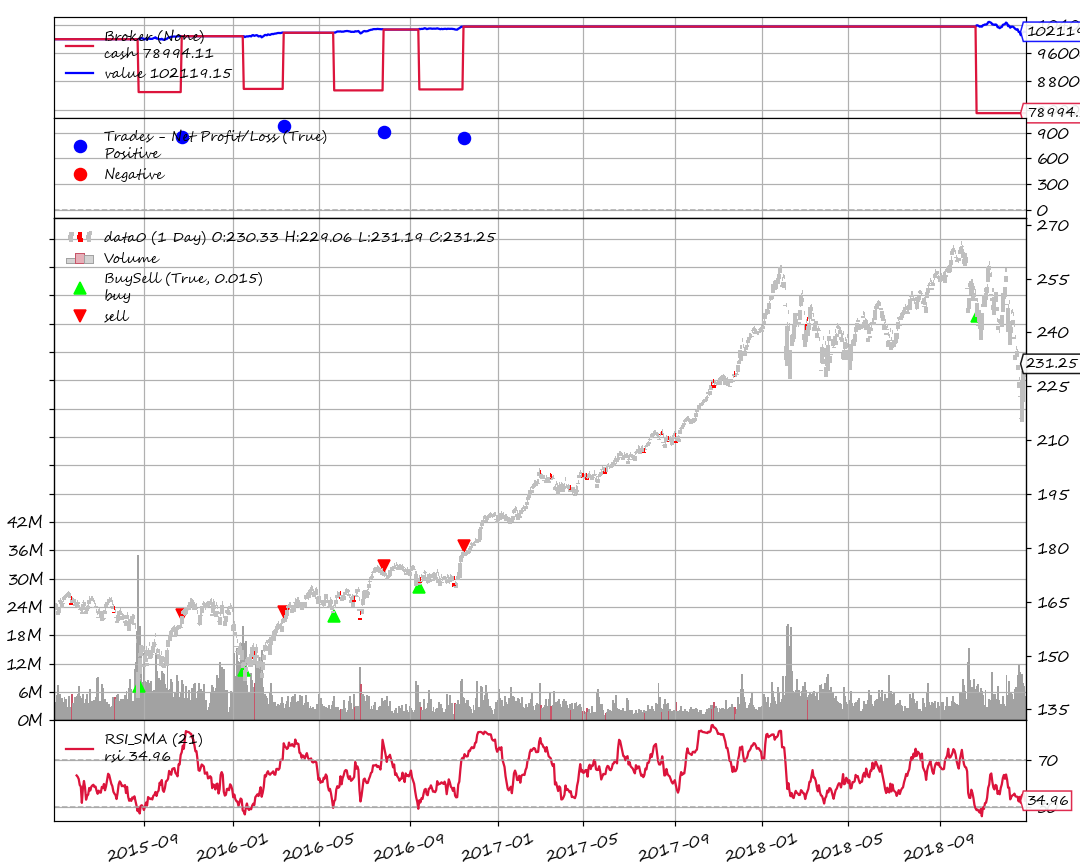

In [26]:
if __name__ == '__main__':
    
    cerebro = bt.Cerebro() # creat the "brain"

    # Add a strategy
    cerebro.addstrategy(RSI_Strategy)

    cerebro.adddata(data_1)
    
    cerebro.broker.setcash(100000.0) # the "manager"
    
    # Set the commission - 0.1% ... divide by 100 to remove the % #手續費
    cerebro.broker.setcommission(commission=0.001)
    
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.run() # run over everything
    
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue()) 
    
    cerebro.plot() # plot the result

Starting Portfolio Value: 100000.00
2015-05-01, Close, 163.89
2015-05-01, BUY CREATE, 163.89
2015-05-04, BUY EXECUTED, Price: 164.19, Cost: 164.19, Comm 0.16
2015-05-04, Close, 164.84
2015-05-05, Close, 164.42
2015-05-06, Close, 164.11
2015-05-07, Close, 163.61
2015-05-08, Close, 165.72
2015-05-11, Close, 165.70
2015-05-11, SELL CREATE, 165.70
2015-05-12, SELL EXECUTED, Price: 163.97, Cost: 164.19, Comm 0.16
2015-05-12, OPERATION PROFIT, GROSS -0.22, NET -0.55
2015-05-12, Close, 165.00
2015-05-12, BUY CREATE, 165.00
2015-05-13, BUY EXECUTED, Price: 164.66, Cost: 164.66, Comm 0.16
2015-05-13, Close, 165.19
2015-05-14, Close, 166.29
2015-05-15, Close, 166.53
2015-05-18, Close, 166.99
2015-05-19, Close, 167.24
2015-05-20, Close, 167.30
2015-05-20, SELL CREATE, 167.30
2015-05-21, SELL EXECUTED, Price: 166.63, Cost: 164.66, Comm 0.17
2015-05-21, OPERATION PROFIT, GROSS 1.98, NET 1.65
2015-05-21, Close, 167.02
2015-05-22, Close, 166.74
2015-05-22, BUY CREATE, 166.74
2015-05-26, BUY EXECUTED,

2016-02-09, BUY EXECUTED, Price: 146.90, Cost: 146.90, Comm 0.15
2016-02-09, Close, 149.61
2016-02-10, Close, 150.39
2016-02-11, Close, 146.42
2016-02-12, Close, 148.24
2016-02-16, Close, 150.38
2016-02-17, Close, 153.13
2016-02-17, SELL CREATE, 153.13
2016-02-18, SELL EXECUTED, Price: 153.19, Cost: 146.90, Comm 0.15
2016-02-18, OPERATION PROFIT, GROSS 6.29, NET 5.99
2016-02-18, Close, 153.30
2016-02-19, Close, 152.35
2016-02-22, Close, 154.82
2016-02-23, Close, 154.17
2016-02-24, Close, 153.37
2016-02-24, BUY CREATE, 153.37
2016-02-25, BUY EXECUTED, Price: 153.49, Cost: 153.49, Comm 0.15
2016-02-25, Close, 155.17
2016-02-26, Close, 156.20
2016-02-29, Close, 155.51
2016-03-01, Close, 156.80
2016-03-02, Close, 157.11
2016-03-03, Close, 157.54
2016-03-03, SELL CREATE, 157.54
2016-03-04, SELL EXECUTED, Price: 157.67, Cost: 153.49, Comm 0.16
2016-03-04, OPERATION PROFIT, GROSS 4.19, NET 3.87
2016-03-04, Close, 158.62
2016-03-07, Close, 158.97
2016-03-08, Close, 158.82
2016-03-09, Close, 15

2017-11-27, Close, 228.93
2017-11-28, Close, 230.97
2017-11-29, Close, 232.14
2017-11-30, Close, 235.86
2017-12-01, Close, 235.81
2017-12-04, Close, 237.88
2017-12-05, Close, 236.15
2017-12-06, Close, 234.92
2017-12-06, BUY CREATE, 234.92
2017-12-07, BUY EXECUTED, Price: 233.65, Cost: 233.65, Comm 0.23
2017-12-07, Close, 235.26
2017-12-08, Close, 236.00
2017-12-11, Close, 236.59
2017-12-12, Close, 238.17
2017-12-13, Close, 239.25
2017-12-14, Close, 239.33
2017-12-14, SELL CREATE, 239.33
2017-12-15, SELL EXECUTED, Price: 239.07, Cost: 233.65, Comm 0.24
2017-12-15, OPERATION PROFIT, GROSS 5.42, NET 4.95
2017-12-15, Close, 239.52
2017-12-18, Close, 241.31
2017-12-19, Close, 241.11
2017-12-20, Close, 241.17
2017-12-21, Close, 241.06
2017-12-22, Close, 240.40
2017-12-22, BUY CREATE, 240.40
2017-12-26, BUY EXECUTED, Price: 239.75, Cost: 239.75, Comm 0.24
2017-12-26, Close, 240.38
2017-12-27, Close, 240.48
2017-12-28, Close, 240.97
2017-12-29, Close, 241.37
2018-01-02, Close, 241.24
2018-01-0

<IPython.core.display.Javascript object>


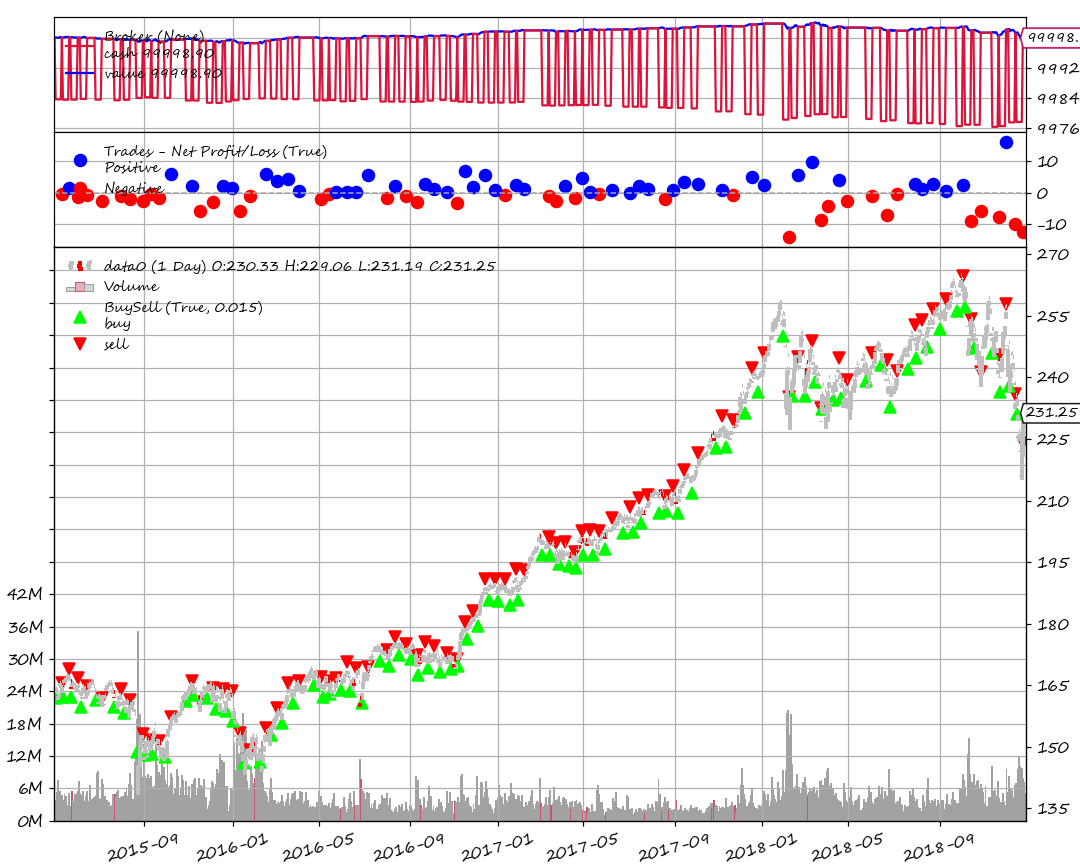

In [31]:
if __name__ == '__main__':
    
    cerebro = bt.Cerebro() # creat the "brain"

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    cerebro.adddata(data_1)
    
    cerebro.broker.setcash(100000.0) # the "manager"
    
    # Set the commission - 0.1% ... divide by 100 to remove the % #手續費
    cerebro.broker.setcommission(commission=0.001)
    
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.run() # run over everything
    
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue()) 
    
    cerebro.plot() # plot the result

[backtrader手冊](https://documents.shangbaoliang.com/backtrader/quickstart/quickstart.html)  
[backtrader回测框架](https://unordered.org/timelines/58bb15f2b8400000)  
[trading-using-sentiment-analysis](https://towardsdatascience.com/https-towardsdatascience-com-algorithmic-trading-using-sentiment-analysis-on-news-articles-83db77966704)  